In [1]:
import torch
import numpy as np
import pandas as pd

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [2]:
device = torch.device("cpu")

In [124]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW, get_scheduler
model_name = "sberbank-ai/sbert_large_nlu_ru"
tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=655)
model = AutoModel.from_pretrained(model_name)
#попробуем позже

In [125]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(120138, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inp

In [37]:
list(model.modules()) # to inspect the modules of your model
model = torch.nn.Sequential(*list(model.modules()))

In [97]:
model.modules

<bound method Module.modules of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
          

In [99]:
for param in model.parameters():
    param.requires_grad=False

In [123]:
model.bert.pooler


BertPooler(
  (dense): Linear(in_features=1024, out_features=1024, bias=True)
  (activation): Tanh()
)

In [107]:
model.parameters#()#requires_grad = True

<bound method Module.parameters of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
       

In [14]:
df = pd.read_csv("../../cleareddata.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['g_id'] = pd.Series(df['g_id']).astype(str)

In [18]:
df.info

<bound method DataFrame.info of                                                    label  g_id
0      прочее мясо рыбы включая фарш мороженые рыбный...  0304
1      растения засушенные обработанные антисептиком ...  0604
2      огурцы корнишоны консервированные для кратковр...  0711
3      овощи сущенные чеснок сушенный хлопья маркиров...  0712
4                  бананы свежие зеленые сорта cavendish  0803
...                                                  ...   ...
83100  сливочные конфеты не содержащие какао тм storc...  1704
83101  пищевой наполнитель для пром произв ва пищевой...  1704
83102  тоффи карамели и аналогичные сладости не содер...  1704
83103  кондитерские изделия из сахара не содержащие к...  1704
83104  кондитерские изделия из сахара не содержaщие к...  1704

[83105 rows x 2 columns]>

In [16]:
g_id = []
for id in df['g_id']:
    if len(id) == 4:
        g_id.append(str(id)[:4])
    else:
        g_id.append('0' + str(id)[:3])
df['g_id'] = g_id

In [17]:
df.value_counts('g_id')

g_id
4011    9178
9503    8446
8708    5612
7318    2668
3926    2168
        ... 
5908       1
6002       1
6005       1
6102       1
0207       1
Length: 655, dtype: int64

In [19]:
df['id'] = df['g_id']
df = df.drop(['g_id'], axis=1, inplace=False)
df

,label,id
0,прочее мясо рыбы включая фарш мороженые рыбный...,0304
1,растения засушенные обработанные антисептиком ...,0604
2,огурцы корнишоны консервированные для кратковр...,0711
3,овощи сущенные чеснок сушенный хлопья маркиров...,0712
4,бананы свежие зеленые сорта cavendish,0803
...,...,...
83100,сливочные конфеты не содержащие какао тм storc...,1704
83101,пищевой наполнитель для пром произв ва пищевой...,1704
83102,тоффи карамели и аналогичные сладости не содер...,1704
83103,кондитерские изделия из сахара не содержащие к...,1704


In [80]:
min_req = 20
filtered_classes = df.g_id.value_counts()[df.g_id.value_counts() > min_req].index.values

df = df[df.g_id.apply(lambda x: True if x in filtered_classes else False)]
df

,id,label,g_id
6,805102000,плоды цитрусовых культур апельсины свежие,0805
7,805210000,плоды цитрусовых культур мандарины свежие,0805
8,805290000,пробы и образцы для проведения работ по оценке...,0805
9,805501000,плоды цитрусовых культур лимоны свежие,0805
10,808108002,яблоки свежие в коробках сорт royal gala в...,0808
...,...,...,...
87483,1704907500,сливочные конфеты не содержащие какао тм sto...,1704
87484,1704907500,пищевой наполнитель для пром произв ва пищевой...,1704
87485,1704907500,тоффи карамели и аналогичные сладости не содер...,1704
87486,1704907500,кондитерские изделия из сахара не содержащие к...,1704


In [6]:
counts = df.value_counts('id')
df_count = pd.DataFrame(data={'id': counts.index, 'count': counts.values})

In [7]:
df_count

,id,count
0,8708299009,2488
1,3926909709,1308
2,8708999709,776
3,9503007500,770
4,8708109009,751
...,...,...
2605,4016950000,1
2606,8425390006,1
2607,4014900000,1
2608,4013100001,1


In [8]:
df_count.to_csv('../../tnveds_sort.csv')

In [74]:
df

,description,labels
0,фитинги для труб или трубок из коррозинностойк...,138
1,инструмент для демонтажа декоративной крышки к...,43
2,бумага из целлюлозных волокон для использовани...,63
3,6600005819 регулятор высоты ремня безопасности...,177
4,упаковка стеклянная для парфюмерно косметическ...,129
...,...,...
86037,игрушки детские имеющие встроенный двигатель ...,295
86038,8891428999 rear bumper body upr верхний элемен...,259
86039,светильники электрические поставляются частич...,294
86040,6666056178 compl a side structure lh левая бок...,259


In [130]:
df = df[df['label'].notnull()]

In [82]:
df['label'] = df['label'].apply(lambda x: ' '.join(x.split()[:400]) if len(x.split())>400 else x)

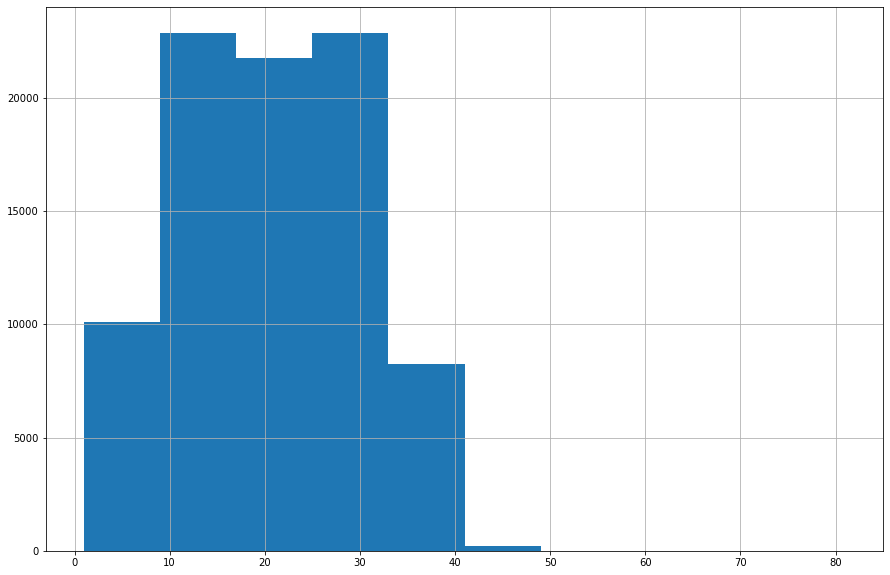

In [41]:
a = df['label'].apply(lambda x: len(x.split())).hist(figsize=(15, 10))

In [83]:
df['label'][df['label'].apply(lambda x: True if len(x.split()) == 1 else False)]

9755         патрубок
10006           хомут
15540          стулья
19710         домкрат
20438        расчёска
             ...     
86179            воск
86517         тoвары 
86655    аhтибиотики 
86931     дипиридaмол
87003     эторикоксиб
Name: label, Length: 92, dtype: object

In [20]:
from sklearn import preprocessing
Label_encoder = preprocessing.LabelEncoder()
Label_encoder.fit(df['id'])

LabelEncoder()

In [21]:
df['id'] = Label_encoder.fit_transform(df['id'])

In [22]:
df

,label,id
0,прочее мясо рыбы включая фарш мороженые рыбный...,1
1,растения засушенные обработанные антисептиком ...,5
2,огурцы корнишоны консервированные для кратковр...,8
3,овощи сущенные чеснок сушенный хлопья маркиров...,9
4,бананы свежие зеленые сорта cavendish,13
...,...,...
83100,сливочные конфеты не содержащие какао тм storc...,38
83101,пищевой наполнитель для пром произв ва пищевой...,38
83102,тоффи карамели и аналогичные сладости не содер...,38
83103,кондитерские изделия из сахара не содержащие к...,38


In [23]:
df.columns = ['description', 'labels']

In [24]:
df

,description,labels
0,прочее мясо рыбы включая фарш мороженые рыбный...,1
1,растения засушенные обработанные антисептиком ...,5
2,огурцы корнишоны консервированные для кратковр...,8
3,овощи сущенные чеснок сушенный хлопья маркиров...,9
4,бананы свежие зеленые сорта cavendish,13
...,...,...
83100,сливочные конфеты не содержащие какао тм storc...,38
83101,пищевой наполнитель для пром произв ва пищевой...,38
83102,тоффи карамели и аналогичные сладости не содер...,38
83103,кондитерские изделия из сахара не содержащие к...,38


In [25]:
df.to_csv('../../cler_enc.csv', index=False)

In [26]:
np.save('./cl_classes.npy', Label_encoder.classes_)

In [27]:
df = df.sample(frac=1).reset_index(drop=True)
train = df[:int(len(df)*0.8)]
test =  df[int(len(df)*0.8):]

In [28]:
print(len(test['labels'].value_counts()))

477


In [29]:
train.to_csv('../../train.csv', index=False)
test.to_csv('../../test.csv', index=False)

In [30]:
model.named_parameters

<bound method Module.named_parameters of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [31]:
torch.cuda.empty_cache()
import gc
gc.collect()

1203

In [5]:
#!pip install datasets

In [32]:
from datasets import load_dataset, load_metric
dataset = load_dataset('csv', data_files={'train': '../../train.csv', 'test': '../../test.csv'})

Extracting data files: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 333.03it/s]


Dataset csv downloaded and prepared to C:/Users/yeril/.cache/huggingface/datasets/csv/default-928fe095dc057ce0/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 181.79it/s]


In [33]:
dataset = dataset.map(lambda e: tokenizer(e['description'], truncation = True, max_length=100, padding='max_length'), batched=True)

In [34]:
pytorch_style_columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']  # 
dataset = dataset.remove_columns(set(dataset['train'].features.keys()) - set(pytorch_style_columns))

In [35]:
set(dataset['train'].features.keys())


{'attention_mask', 'input_ids', 'labels', 'token_type_ids'}

In [36]:
dataset.set_format(type='torch', columns=pytorch_style_columns, device='cuda') 

In [37]:
dataset.shape

{'train': (66484, 4), 'test': (16621, 4)}

In [38]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=1)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=1)
#если есть видеопамять около 10гб, можно поставить 8

In [48]:
len(train_dataloader)

8311

In [39]:

optimizer = AdamW(model.parameters(), lr=2e-6)

num_epochs = 15

num_training_steps = num_epochs * len(train_dataloader)


lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=2000,
    num_training_steps=num_training_steps
)

C:\Users\yeril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
torch.cuda.empty_cache()
import gc
gc.collect()

42

In [44]:
from tqdm import tqdm

In [41]:
#next(iter(train_dataloader))
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024

In [42]:
num_epochs = 15

In [45]:
best_f1 = 0.
show_train_loss_every_num_epoch = 0.1

for epoch in range(num_epochs):
    print(40*'-', '\nepoch', epoch+1)
    model.train()
    losses = []

    for i, batch in enumerate(tqdm(train_dataloader)):
        model.train()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        losses.append(loss.item())

        #f i%int(len(train_dataloader)*show_train_loss_every_num_epoch)==int(len(train_dataloader)*show_train_loss_every_num_epoch)-1:
    print(f'train loss [{i*100/len(train_dataloader):.2f}%]: {np.array(losses).mean():.3f}')
    losses = []
    print('\nvalidating')

    f1 = load_metric('f1')
    acc = load_metric('accuracy')
    precision = load_metric('precision')
    recall = load_metric('recall')
    with torch.no_grad():
        model.eval()
                
        for batch in tqdm(test_dataloader):
        ##for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            f1.add_batch(predictions=predictions, references=batch["labels"])    
            acc.add_batch(predictions=predictions, references=batch["labels"])    
            precision.add_batch(predictions=predictions, references=batch["labels"])    
            recall.add_batch(predictions=predictions, references=batch["labels"])    

        print('weighted summary:')
        print('Test acc:', acc.compute()['accuracy'])
        print('Test precision:', precision.compute(average = 'weighted')['precision'])
        print('Test recall:', recall.compute(average = 'weighted')['recall'])
        f1_weighted = f1.compute(average = 'weighted')['f1']
        print('Test f1:', f1_weighted, '\n')

        if f1_weighted > best_f1:
            best_f1 = f1_weighted
            model.save_pretrained("../../best_model3004")

    model.train()

---------------------------------------- 
epoch 1


  0%|                                                                                        | 0/66484 [00:05<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 470.00 MiB (GPU 0; 4.00 GiB total capacity; 3.20 GiB already allocated; 0 bytes free; 3.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
from sklearn import preprocessing
from sklearn.metrics import classification_report
Label_encoder = preprocessing.LabelEncoder()
Label_encoder.classes_ = np.load('./classes.npy', allow_pickle=True)

true = []
preds = []

model.eval()
for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    true += batch["labels"].detach().cpu().numpy().tolist()
    preds += predictions.detach().cpu().numpy().tolist()

print(classification_report(Label_encoder.inverse_transform(true), Label_encoder.inverse_transform(preds)))

100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:45<00:00, 13.01it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        0805       0.00      0.00      0.00         9
        0808       1.00      0.38      0.55        16
        1704       0.38      1.00      0.56        80
        1905       0.00      0.00      0.00        14
        2003       0.88      1.00      0.94        15
        2007       0.00      0.00      0.00         7
        2009       0.00      0.00      0.00         8
        2105       0.00      0.00      0.00         8
        2106       1.00      0.17      0.29        30
        2202       0.00      0.00      0.00         3
        2710       0.00      0.00      0.00         8
        2918       0.00      0.00      0.00        29
        2924       0.00      0.00      0.00        27
        2933       0.19      0.76      0.31        55
        2934       0.00      0.00      0.00        36
        2941       0.00      0.00      0.00        22
        3005       1.00      1.00      1.00        14
        3206       1.00    

/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
inputs = tokenizer('покрышки', truncation = True, max_length=100, padding='max_length', return_tensors="pt")
#batch = {k: torch.tensor(v).to(device) for k, v in txt.items()}
model.to(torch.device('cpu'))
with torch.no_grad():
    logits = model(**inputs).logits
predicted_class_id = logits.argmax().item()
#Label_encoder.inverse_transform(predicted_class_id)
a = []
a.append(predicted_class_id)

In [114]:
Label_encoder.inverse_transform([a])

array(['4011'], dtype=object)

In [17]:
def predict_class(text):
    model.to(torch.device('cpu'))
    inputs = tokenizer(text, truncation = True, max_length=100, padding='max_length', return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        return Label_encoder.inverse_transform([predicted_class_id])


In [19]:
print(predict_class("Велосипед"), predict_class("велосипед"), predict_class("Велосипедов"))

['9503'] ['9503'] ['8714']


In [127]:
def get_tensor(text):
    model.to(device)
    inputs = tokenizer(text, truncation = True, max_length=100, padding='max_length', return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs)#.logits
        #predicted_class_id = logits.argmax().item()
        #return Label_encoder.inverse_transform([predicted_class_id])
        return logits

In [161]:
a = get_tensor("ручка шариковая")
b = get_tensor('шариковая ручка')
c = get_tensor('ручка гелевая')
d = get_tensor('ручка дверная')

In [129]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:# Euclidian
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),0)
    elif distance_metric==1:#cosine
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=0)
        norm = np.linalg.norm(embeddings1, axis=0) * np.linalg.norm(embeddings2, axis=0)
        similarity = dot / norm
        dist = np.arccos(similarity) / np.pi
    else:
        raise 'Undefined %d' % distance_metric
    return dist

def get_distance(id1, id2, metric=1):
    label1 = df['label'][id1] if type(id1) == int else str(id1)
    label2 = df['label'][id2] if type(id2) == int else str(id2)
    print(f'distance between {label1} and {label2}: {distance(get_embs(label1), get_embs(label2), distance_metric=metric)}')

In [133]:
a

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0798, -0.4060, -0.6245,  ...,  0.4242, -0.4087,  0.1709],
         [-0.5661, -0.2637, -0.4920,  ...,  0.2970, -0.5419,  0.4877],
         [-0.0486, -0.4097, -0.5045,  ...,  0.6356, -0.6258,  0.1036],
         ...,
         [-0.2670, -0.4212, -0.1372,  ...,  0.4249, -0.6623,  0.3343],
         [-0.2686, -0.4472, -0.1657,  ...,  0.2780, -0.7783, -0.0014],
         [-0.1532, -0.3804, -0.1367,  ...,  0.3282, -0.8274,  0.1027]]]), pooler_output=tensor([[ 0.4689,  0.3722, -0.8089,  ..., -0.2569,  0.9910, -0.1870]]), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None)

In [146]:
a[0][0][6]#.shape#.numpy()

tensor([-0.3144, -0.4836, -0.2121,  ...,  0.4556, -0.6576, -0.0948])

In [159]:
distance(a[0][0].numpy(), b[0][0].numpy(), distance_metric=1).mean()#.shape

0.17564651

In [160]:
distance(a[0][0].numpy(), c[0][0].numpy(), distance_metric=1).mean()

0.18894556

In [162]:
distance(a[0][0].numpy(), d[0][0].numpy(), distance_metric=1).mean()

0.20799857